In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
from FixedPoint import FXnum
import datetime as dt
from enum import Enum

In [2]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = .25/3600
Ki = .25/3600**2
t = 15
delta_t = [3600] * t
market_prices = [1] + [1.01]*(t-1)
save_dir = "test/saved_sims/pi_validator/raw/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp*1e18)),
  "Ki": str(int(Ki*1e18)),
  "lower_precomputed_rate_allowed_deviation": "985000000000000000",
  "upper_precomputed_rate_allowed_deviation": "980000000000000000",
  "allowed_deviation_increase": "1000000000000000000000000000",
  "noise_barrier": "1000000000000000000",
  "per_second_leak": "1000000000000000000000000000",
  "min_rate_timeline": "2592000",
  "oracle_initial_price": "1000000000000000000",
  "initial_redemption_price": "1000000000000000000000000000",
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

import json
with open('../geb-rrfm-truffle-sims/test/config/pi_raw.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "kp": Kp,
  "ki": Ki,
  "lower_precomputed_rate_allowed_deviation": 985000000000000000,
  "upper_precomputed_rate_allowed_deviation": 980000000000000000,
  "allowed_deviation_increase": 1000000000000000000000000000,
  "noise_barrier": 1000000000000000000,
  "per_second_leak": 1000000000000000000000000000,
  "min_rate_timeline": 2592000,
  "oracle_initial_price": 1000000000000000000,
  "initial_redemption_price": 1000000000000000000000000000,
  "delta_t": delta_t,
  "market_prices": market_prices,
}



In [3]:
import os
os.chdir('/Users/markusbkoch/Documents/GitHub/geb-rrfm-truffle-sims')
!npm run pi-raw-imported-config


> geb-rrfm-truffle-sims@1.0.0 pi-raw-imported-config /Users/markusbkoch/Documents/GitHub/geb-rrfm-truffle-sims
> truffle test test/pi_raw_validator_imported_config.js


Compiling your contracts...
> Compiling ./contracts/Migrations.sol
> Compiling ./contracts/mock/AGUpdater.sol
> Compiling ./contracts/mock/MockOracleRelayer.sol
> Compiling ./contracts/mock/MockRateSetter.sol
> Compiling ./contracts/mock/MockTreasury.sol
> Compiling ./contracts/mock/SeedProposerUpdater.sol
> Compiling ./contracts/oracle/MockFeed.sol
> Compiling ./contracts/setter/RateSetter.sol
> Compiling ./contracts/setter/RateSetterMath.sol
> Compiling ./contracts/token/Address.sol
> Compiling ./contracts/token/Context.sol
> Compiling ./contracts/token/ERC20.sol
> Compiling ./contracts/token/IERC20.sol
> Compiling ./contracts/token/OriginalSafeMath.sol
> Compiling ./contracts/validator/math/SafeMath.sol
> Compiling ./contracts/validator/math/SignedSafeMath.sol
> Compiling ./contracts/validator/raw/PIRawValidator.sol

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [4]:
from models.market_model.model.state_variables import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = FXnum(int(config_file[k][0]))
            except:
                base_genesis_states[k] = FXnum(int(config_file[k]))
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [5]:
from models.market_model.model.parts.sys_params import params

def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [FXnum(config_file[k])]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict


test_specific_params = pre_process_params_dict(params)

In [6]:
T = 0
for k in config_file.keys():
    if type(config_file[k]) == list:
        T = len(config_file[k])-1
        break

In [7]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.market_model.model.parts.controllers import *
from models.market_model.model.parts.markets import *
from models.market_model.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [8]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(T),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)


exp.append_configs(initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (14, 30, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.05s


In [9]:
full = pd.DataFrame(raw_result)

In [10]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

fx_cols = ['error_star', 'error_hat', 'old_error_star', 'old_error_hat',
       'error_star_integral', 'error_hat_integral', 'error_star_derivative',
       'error_hat_derivative', 'target_rate', 'target_price', 'market_price',
       'debt_price', 'timedelta']
for c in fx_cols:
    df[c] = df[c].apply(float)

In [11]:
data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

for c in data.columns:
    data[c]=data[c].apply(float)
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45
#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)']/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)']/RAY - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()
data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


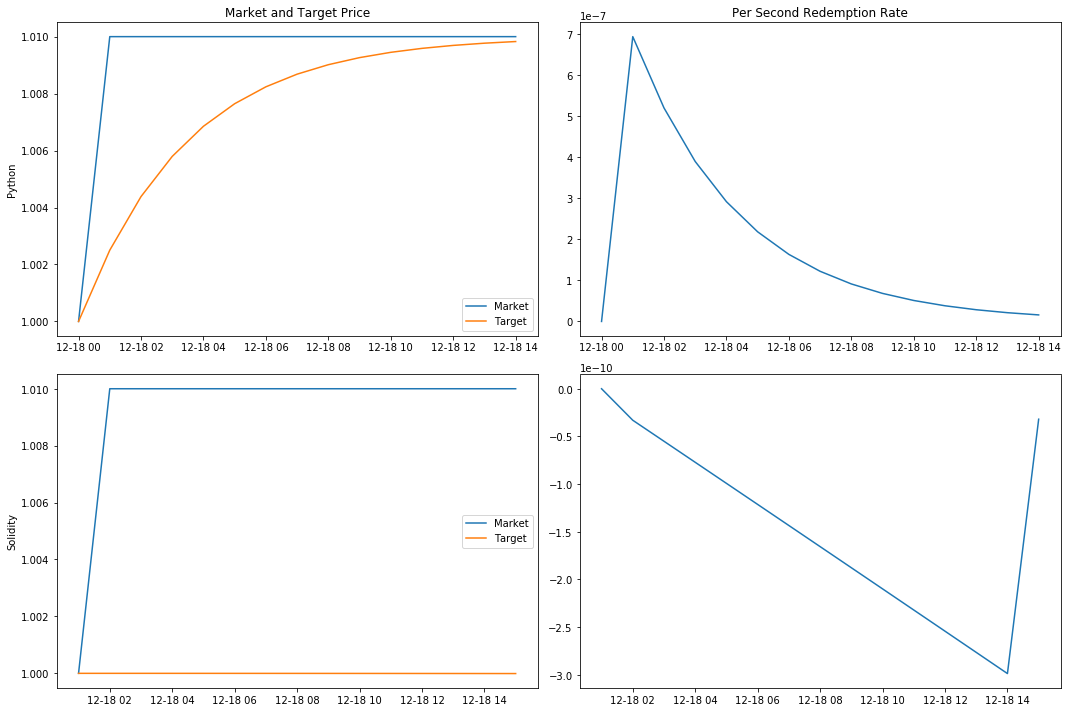

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(15,10))
i = 0
axs.flat[i].plot(df['timestamp'], df['market_price'], label='Market')
axs.flat[i].plot(df['timestamp'], df['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(df['timestamp'], df['target_rate'])
axs.flat[i].set_title('Per Second Redemption Rate')

i += 1 
axs.flat[i].plot(data['timestamp'], data['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(data['timestamp'], data['RedemptionPrice(USD)'], label='Target')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(data['timestamp'], data['PerSecondRedemptionRate(float)'])


fig.tight_layout()
plt.show()

In [13]:
#python script stores result of the simulation in a predetermined location

In [14]:
#jupyter notebook shows visualizations of the results from solidity 
#implementation and cadCAD model and error metrics